![JohnSnowLabs](https://sparknlp.org/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp/blob/master/examples/python/annotation/image/CLIPForZeroShotClassification.ipynb)

In [ ]:
! wget -q http://setup.johnsnowlabs.com/colab.sh -O - | bash

## CLIPForZeroShotClassification Annotator

In this notebok we are going to classify some images while providing the labels at inference time. For this we will use the CLIP model published by OpenAI. The model encodes images and candidate labels will output the most likely label per image.

### Downloading Images

In [ ]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/images.zip

In [ ]:
import shutil
shutil.unpack_archive("images.zip", "images", "zip")

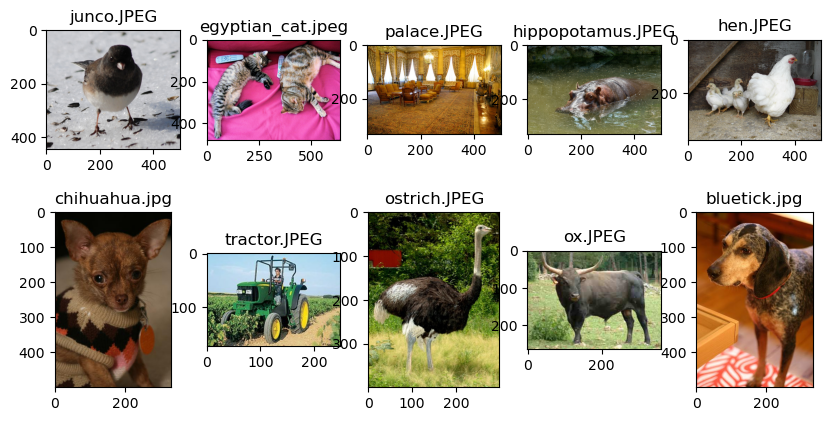

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

_, axes = plt.subplots(2, 5, figsize=(10,5))
axes = axes.flatten()

i = 0
for file_name in os.listdir("images/images/"):
    if file_name.lower().endswith((".png", ".jpg", ".jpeg", ".gif")):
        file_path = os.path.join("images/images/", file_name)
        ax = axes[i]
        ax.imshow(Image.open(file_path).convert("RGB"))
        ax.title.set_text(file_name)
        i += 1

### Start Spark Session

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql import SparkSession

spark = sparknlp.start()

In [ ]:
data_df = spark.read.format("image").option("dropInvalid", value = True).load(path="images/images/")

### Pipeline with CLIPForZeroShotClassification

In [ ]:
image_assembler = ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

labels = [
    "a photo of a bird",
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a hen",
    "a photo of a hippo",
    "a photo of a room",
    "a photo of a tractor",
    "a photo of an ostrich",
    "a photo of an ox",
]

image_captioning = CLIPForZeroShotClassification \
    .pretrained() \
    .setInputCols(["image_assembler"]) \
    .setOutputCol("label") \
    .setCandidateLabels(labels)

pipeline = Pipeline(stages=[
    image_assembler,
    image_captioning,
])

In [ ]:
model = pipeline.fit(data_df)
image_df = model.transform(data_df)
image_df \
    .selectExpr("reverse(split(image.origin, '/'))[0] as image_name", "label.result") \
    .show(truncate = False)

+-----------------+-----------------------+
|image_name       |result                 |
+-----------------+-----------------------+
|palace.JPEG      |[a photo of a room]    |
|egyptian_cat.jpeg|[a photo of a cat]     |
|hippopotamus.JPEG|[a photo of a hippo]   |
|hen.JPEG         |[a photo of a hen]     |
|ostrich.JPEG     |[a photo of an ostrich]|
|junco.JPEG       |[a photo of a bird]    |
|bluetick.jpg     |[a photo of a dog]     |
|chihuahua.jpg    |[a photo of a dog]     |
|tractor.JPEG     |[a photo of a tractor] |
|ox.JPEG          |[a photo of an ox]     |
+-----------------+-----------------------+



### Light Pipeline

To use the annotator in a light pipeline, we need to use the new method `fullAnnotateImage`, which can receive 3 kinds of input:
1. A path to a single image
2. A path to a list of images

In [ ]:
light_pipeline = LightPipeline(model)
annotations_result = light_pipeline.fullAnnotateImage("images/images/hippopotamus.JPEG")
annotations_result[0].keys()

dict_keys(['image_assembler', 'label'])

To process a list of images, we just pass a list of images.

In [ ]:
images = ["images/images/bluetick.jpg", "images/images/palace.JPEG", "images/images/hen.JPEG"]
annotations_result = light_pipeline.fullAnnotateImage(images)
annotations_result[0].keys()

dict_keys(['image_assembler', 'label'])

In [ ]:
for result in annotations_result:
  print(result['label'])

[Annotation(category, 0, 15, a photo of a dog, Map(a photo of an ox -> 0.0059416154, nChannels -> 3, a photo of a hippo -> 0.0019135473, a photo of a dog -> 0.9767271, image -> 0, height -> 500, a photo of an ostrich -> 1.9431021E-4, a photo of a bird -> 8.534082E-4, a photo of a room -> 2.1764866E-4, a photo of a tractor -> 3.0925617E-4, origin -> images/images/bluetick.jpg, mode -> 16, a photo of a hen -> 0.00915298, a photo of a cat -> 0.0046901032, width -> 333), [])]
[Annotation(category, 0, 16, a photo of a room, Map(a photo of an ox -> 1.8851699E-4, nChannels -> 3, a photo of a hippo -> 1.3840283E-5, a photo of a dog -> 9.261268E-5, image -> 0, height -> 334, a photo of an ostrich -> 6.571947E-5, a photo of a bird -> 3.7911654E-5, a photo of a room -> 0.99943, a photo of a tractor -> 2.7215643E-5, origin -> images/images/palace.JPEG, mode -> 16, a photo of a hen -> 8.122363E-5, a photo of a cat -> 6.298254E-5, width -> 500), [])]
[Annotation(category, 0, 15, a photo of a hen, Ma